# GOAT: Generalized Oracle for Ailment Tracking

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

# Part 1: Load data into Colab

In [21]:
# Import file and store it in a data frame
df = pd.read_csv('../data/TrainingData/Diacousin.csv')

def condition_int(cond):
  if cond =='Heart Failure':
    return int(0)
  elif cond == 'Diabetes':
    return int(1)
  elif cond == 'Chronic Kidney Disease':
    return int(2)

df['Condition'] = df['Condition'].apply(lambda x: condition_int(x))

df.dropna(inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)
df

,GENDER,Condition,diastolica,sistolica,ritmo_cardiaco,temp,glucosa,altura
0,M,0.0,65.000000,172.000000,79.000000,37.222220,139.567073,1.680000
1,F,1.0,65.000000,71.000000,101.000000,35.634259,136.130719,1.600000
3,M,0.0,61.000000,115.000000,65.000000,37.134528,139.567073,1.680000
5,M,0.0,48.000000,132.000000,84.000000,37.134528,139.567073,1.680000
9,M,0.0,56.000000,155.000000,83.000000,37.944447,139.567073,1.680000
...,...,...,...,...,...,...,...,...
29313,M,0.0,70.183453,117.399281,105.066298,37.674402,108.000000,1.800000
29315,M,0.0,61.243028,124.268775,70.000000,37.011696,135.500000,1.600000
29317,M,0.0,68.063364,115.749137,91.491168,36.812157,117.717647,1.763333
29318,M,0.0,68.063364,115.749137,90.000000,36.812157,117.717647,1.763333


# Part 2: Format data and split it into numpy arrays

In [22]:
def gender_to_categorical(gen):
  enc = OneHotEncoder(sparse=False)
  WD = enc.fit_transform(gen)
  print("== categories:", enc.categories_, "==")
  return WD, [item for sublist in enc.categories_ for item in sublist]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


== categories: [array(['F', 'M'], dtype=object)] ==
Input values X with shape (13437, 8). With values


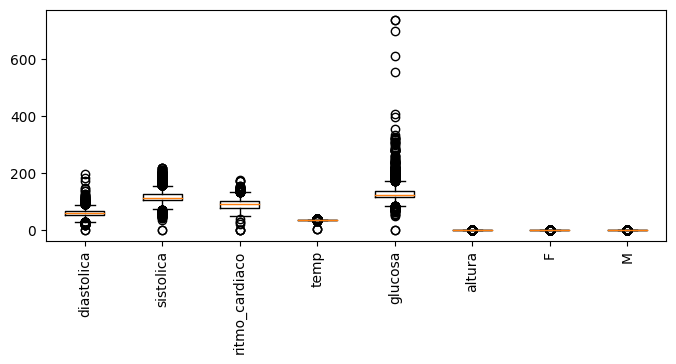

,0,1,2,3,4,5,6,7
count,13437.000000,13437.000000,13437.000000,13437.000000,13437.000000,13437.000000,13437.000000,13437.000000
mean,59.935516,116.485745,91.591283,36.998926,130.041807,1.714192,0.177942,0.822058
std,11.633817,19.204383,16.303456,0.708280,24.946564,0.074770,0.382478,0.382478
min,0.000000,0.000000,0.000000,3.222222,0.000000,1.550000,0.000000,0.000000
25%,53.000000,105.000000,80.000000,36.812157,117.717647,1.680000,0.000000,1.000000
50%,59.647841,115.000000,91.491168,37.134528,125.264637,1.730000,0.000000,1.000000
75%,68.063364,126.000000,102.000000,37.151468,139.567073,1.763333,0.000000,1.000000
max,197.000000,220.000000,176.000000,39.944447,736.000000,1.830000,1.000000,1.000000


In [23]:
# Extract input features and convert them to a numpy array
labels = ['diastolica', 'sistolica', 'ritmo_cardiaco', 'temp', 'glucosa', 'altura']
X = df[labels].to_numpy()
WD, categories = gender_to_categorical(df[['GENDER']])
X = np.concatenate((X, WD), axis=1)

print(f"Input values X with shape {X.shape}. With values")

plt.figure(figsize=(8, 3))
plt.boxplot(X)
plt.xticks(range(1, 9), labels + categories, rotation=90)
plt.show()

pd.DataFrame(X).describe()

In [24]:
# Extract output features and convert them to a numpy array
Y = df[['Condition']].to_numpy()

pd.DataFrame(Y).describe()

,0
count,13437.000000
mean,0.502940
std,0.718857
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [25]:
# Split data into train+val and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(12093, 8)
(12093, 1)
(1344, 8)
(1344, 1)


In [26]:
from keras.utils import np_utils
y_train=np_utils.to_categorical(y_train)
y_test=np_utils.to_categorical(y_test)

# Part 3: Create DNN model and train it

In [27]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.6 MB/s eta 0:00:00


In [28]:
# tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

# 3.1 Auto tuning of hyperparams: number of layers, number of units, and optimizer

In [32]:
def model_builder(hp):
  ''' Define a auxiliar function to create DNN models with varying
      hyperparameters.
  '''
  model = Sequential()
  model.add(InputLayer(input_shape=x_train.shape[1:], name='INPUT'))

  # Choose optimal number of layers between 2 and 8
  for i in range(hp.Int('num_layers', 2, 8)):
    # Tune the number of units in the each dense layer
    hp_units = hp.Int('units_'+str(i), min_value=64, max_value=1024, step=64)
    model.add(Dense(units=hp_units, activation='tanh'))
  # Add output layer
  model.add(Dense(units=y_train.shape[1], name='OUTPUT', activation='sigmoid'))

  # Choose best optimizer
  model.compile(optimizer=hp.Choice('optimizer', values=['sgd', 'adam', 'adagrad', 'adadelta']), loss=tf.keras.losses.CategoricalCrossentropy(), 
                metrics=['accuracy', tf.keras.metrics.Recall(),
     tf.keras.metrics.Precision()])
  
  return model

In [33]:
# Create a tuner and show the search space
tuner = RandomSearch(model_builder,
                     objective='val_loss',
                     max_trials=64)

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'adam', 'adagrad', 'adadelta'], 'ordered': False}


In [34]:
# Make an initial quick exploration of the hyperparam space
tuner.search(x_train, y_train, epochs=10, validation_split=0.1)

Trial 64 Complete [00h 00m 26s]
val_loss: 0.5183954238891602

Best val_loss So Far: 0.38334912061691284
Total elapsed time: 00h 27m 52s


In [35]:
# Get the top model
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192)               1728      
                                                                 
 dense_1 (Dense)             (None, 320)               61760     
                                                                 
 dense_2 (Dense)             (None, 192)               61632     
                                                                 
 OUTPUT (Dense)              (None, 3)                 579       
                                                                 
Total params: 125,699
Trainable params: 125,699
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Create a new model using the best hyperparams
DNN = model_builder(tuner.get_best_hyperparameters()[0])
DNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 192)               1728      
                                                                 
 dense_4 (Dense)             (None, 320)               61760     
                                                                 
 dense_5 (Dense)             (None, 192)               61632     
                                                                 
 OUTPUT (Dense)              (None, 3)                 579       
                                                                 
Total params: 125,699
Trainable params: 125,699
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Full training of best model
H = DNN.fit(x=x_train, y=y_train, batch_size=64, epochs=500, validation_split=0.1)

Epoch 1/500
171/171 [==============================] - 3s 6ms/step - loss: 0.5892 - accuracy: 0.7695 - recall_1: 0.9208 - precision_1: 0.5736 - val_loss: 0.6232 - val_accuracy: 0.7694 - val_recall_1: 0.8769 - val_precision_1: 0.6711
Epoch 2/500
171/171 [==============================] - 1s 4ms/step - loss: 0.5201 - accuracy: 0.7997 - recall_1: 0.9136 - precision_1: 0.6360 - val_loss: 0.5157 - val_accuracy: 0.8083 - val_recall_1: 0.9140 - val_precision_1: 0.6419
Epoch 3/500
171/171 [==============================] - 1s 6ms/step - loss: 0.4735 - accuracy: 0.8236 - recall_1: 0.9207 - precision_1: 0.6523 - val_loss: 0.4909 - val_accuracy: 0.8149 - val_recall_1: 0.8909 - val_precision_1: 0.7201
Epoch 4/500
171/171 [==============================] - 1s 7ms/step - loss: 0.4563 - accuracy: 0.8279 - recall_1: 0.9313 - precision_1: 0.6425 - val_loss: 0.5185 - val_accuracy: 0.8033 - val_recall_1: 0.9050 - val_precision_1: 0.6152
Epoch 5/500
171/171 [==============================] - 1s 6ms/step -

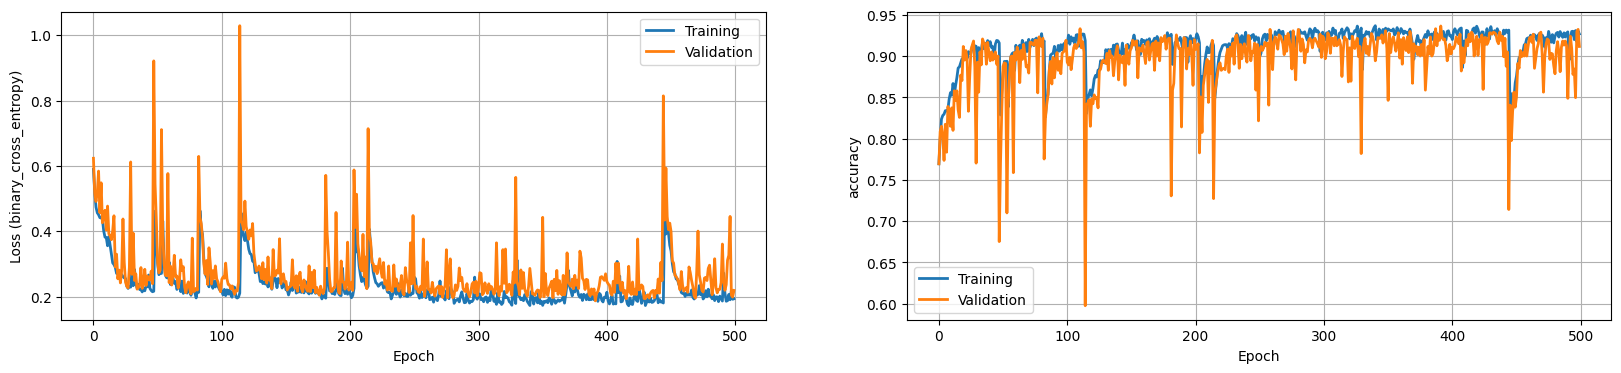

In [38]:
# Plot loss
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(DNN.history.history['loss'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_cross_entropy)')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(DNN.history.history['accuracy'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.grid()
plt.show()

In [39]:
# Compute test loss
loss_test = DNN.evaluate(x=x_test, y=y_test, verbose=False)
print("Test loss and accuracy:", loss_test)

Test loss and accuracy: [0.21710556745529175, 0.921875, 0.9821428656578064, 0.6670035123825073]


In [43]:
y_test

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [47]:
# Predict on test set
y_test_hat = DNN.predict(x=x_test)
new_m = np.zeros_like(y_test_hat)

# get the indices of max elements in each array
max_idxs = np.argmax(y_test_hat, axis=1)

# set those elements to 1
for i in range(y_test_hat.shape[0]):
    new_m[i, max_idxs[i]] = 1

error = np.mean( y_test != new_m )
print(error)

42/42 [==============================] - 0s 2ms/step
0.052083333333333336


# Part 4: save model to disk and load it back





In [42]:
# Save model to disk, then delete it

DNN.save("GOAT.h5")

del DNN

In [46]:
# Load model back into memory, and use it for prediction
from tensorflow.keras.models import load_model
DNN = load_model("GOAT.h5")

y_test_hat = DNN.predict(x=x_test)
print(y_test_hat.shape)

42/42 [==============================] - 0s 3ms/step
(1344, 3)
